# Store Sales Machine Learning Algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import root_mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRFRegressor

Leitura dos Dados nos arquivos .csv

In [2]:
# Lê os dados nos arquivos .csv
dtype_train = {
    'store_nbr': 'uint64',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
train = pd.read_csv(
    'data/train.csv',
    dtype=dtype_train,
    parse_dates=['date'],
)
test = pd.read_csv(
    'data/test.csv',
    dtype=dtype_train,
    parse_dates=['date'],
)
dtype_store = {
    'store_nbr': 'uint64',
    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'uint64',
}
stores = pd.read_csv(
    'data/stores.csv',
    dtype=dtype_store,
)
oil = pd.read_csv(
    'data/oil.csv',
    dtype={
        'dcoilwtico': 'float32'
    },
    parse_dates=['date'],
)
dtype_holiday = {
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    }
holidays = pd.read_csv(
    'data/holidays_events.csv',
    dtype=dtype_holiday,
    parse_dates=['date'],
)
dtype_transaction = {
    'store_nbr': 'uint64',
    'transactions': 'uint64',
}
transactions = pd.read_csv(
    'data/transactions.csv',
    dtype=dtype_transaction,
    parse_dates=['date'],
)

## Tratamento inicial dos dados das tabelas
Aqui fazemos conversões de datas para não correr o risco de ter datas em string e podermos fazer comparações e ordenações com elas. Além de tratarmos valores faltantes e multiplos registros

In [3]:
# Conversão das datas para datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
# Tratamento de multiplos preços de petróleo por dia tirando a média
oil = oil.set_index('date').resample('D').mean()
# Preenchendo valores faltantes de preços de petróleo com forward fill e depois backward fill
oil['dcoilwtico'] = oil['dcoilwtico'].ffill().bfill()
oil = oil.reset_index()
# Remoção dos feriados transferidos
holidays = holidays[holidays['transferred'] == False]
holidays = holidays.drop(['transferred'], axis=1)

## Análise Exploratória dos dados
Aqui buscamos gerar gráficos para observar padrões noa dados e conseguir extrair features a partir deles.

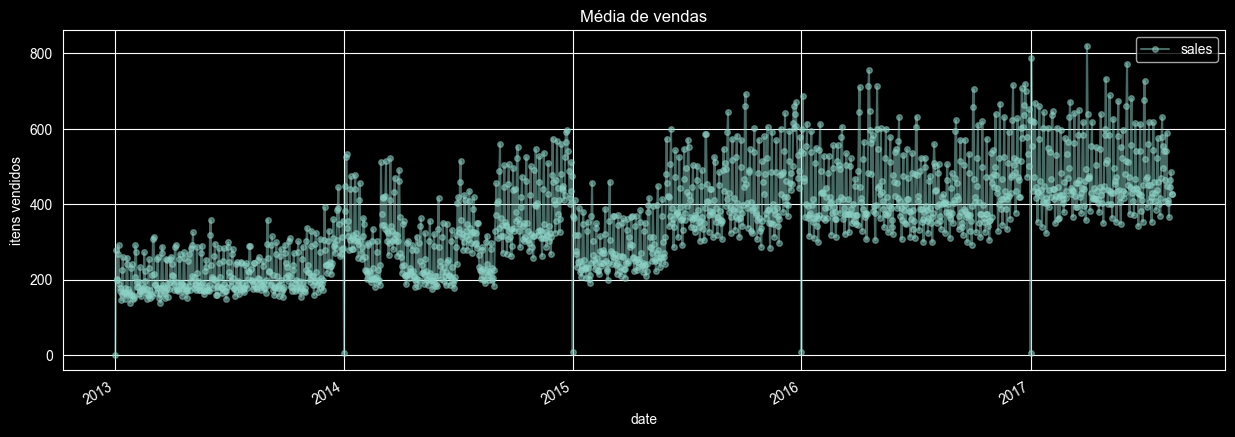

In [5]:
average_sales = train.groupby('date')['sales'].mean()
ax = average_sales.plot(marker='o', markersize=4, alpha=0.5, title="Média de vendas", ylabel="itens vendidos", figsize=(15, 5))
ax.legend()

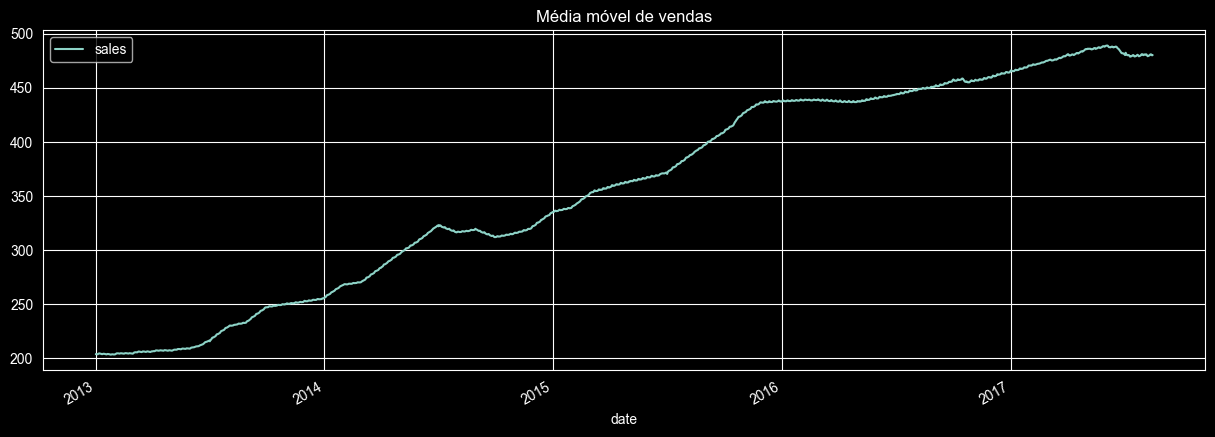

In [6]:
moving_average_sales = average_sales.rolling(window=365, center=True, min_periods=183).mean()
ax = moving_average_sales.plot(title='Média móvel de vendas', figsize=(15, 5))
ax.legend()

C:\Users\ACER\AppData\Local\Temp\ipykernel_1432\3882409083.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(holidays_sample['date'], holidays_sample_sales[holidays_sample['date']], color='C3')
C:\Users\ACER\AppData\Local\Temp\ipykernel_1432\3882409083.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot_date(holidays_sample['date'], holidays_sample_sales[holidays_sample['date']], color='C3')


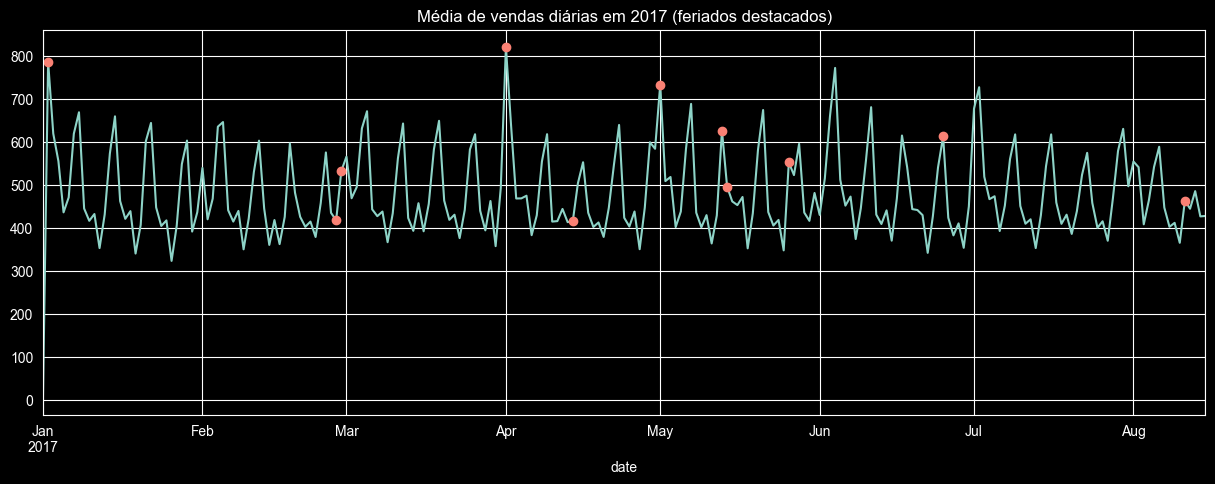

In [7]:
holidays_sample = holidays.query("locale in ['National', 'Regional'] and '2017-01-01' <= date <= '2017-08-15'")
holidays_sample_sales = average_sales.loc['2017']
ax = holidays_sample_sales.plot(figsize=(15, 5))
plt.plot_date(holidays_sample['date'], holidays_sample_sales[holidays_sample['date']], color='C3')
ax.set_title('Média de vendas diárias em 2017 (feriados destacados)');

In [8]:
average_sales_df = pd.DataFrame({'date': average_sales.index, 'sales': average_sales.values})
average_sales_df['lag_16'] = average_sales_df['sales'].shift(16)

[None,
 Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'lag_16'),
 Text(0.5, 1.0, 'Plotagem do Lag de 16 dias para média de vendas')]

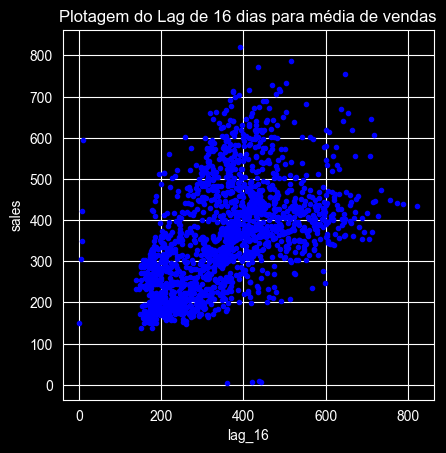

In [9]:
fig, ax = plt.subplots()
ax.plot(average_sales_df['lag_16'], average_sales_df['sales'], '.', color='blue')
ax.set(aspect='equal', ylabel='sales', xlabel='lag_16', title='Plotagem do Lag de 16 dias para média de vendas')

[Text(0, 0.5, 'media de vendas'),
 Text(0.5, 0, 'preço do petróleo no dia'),
 Text(0.5, 1.0, 'Relação Preço do Petróleo vs Vendas')]

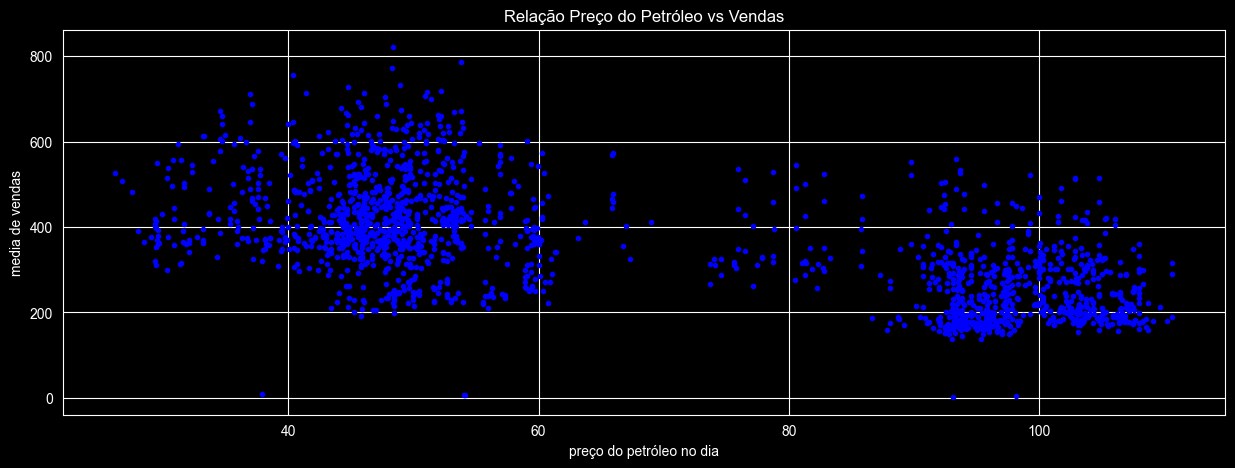

In [13]:
df_oil_plot = average_sales_df.merge(oil, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_oil_plot['dcoilwtico'], df_oil_plot['sales'], '.', color='blue')
ax.set(ylabel='media de vendas', xlabel='preço do petróleo no dia', title='Relação Preço do Petróleo vs Vendas')

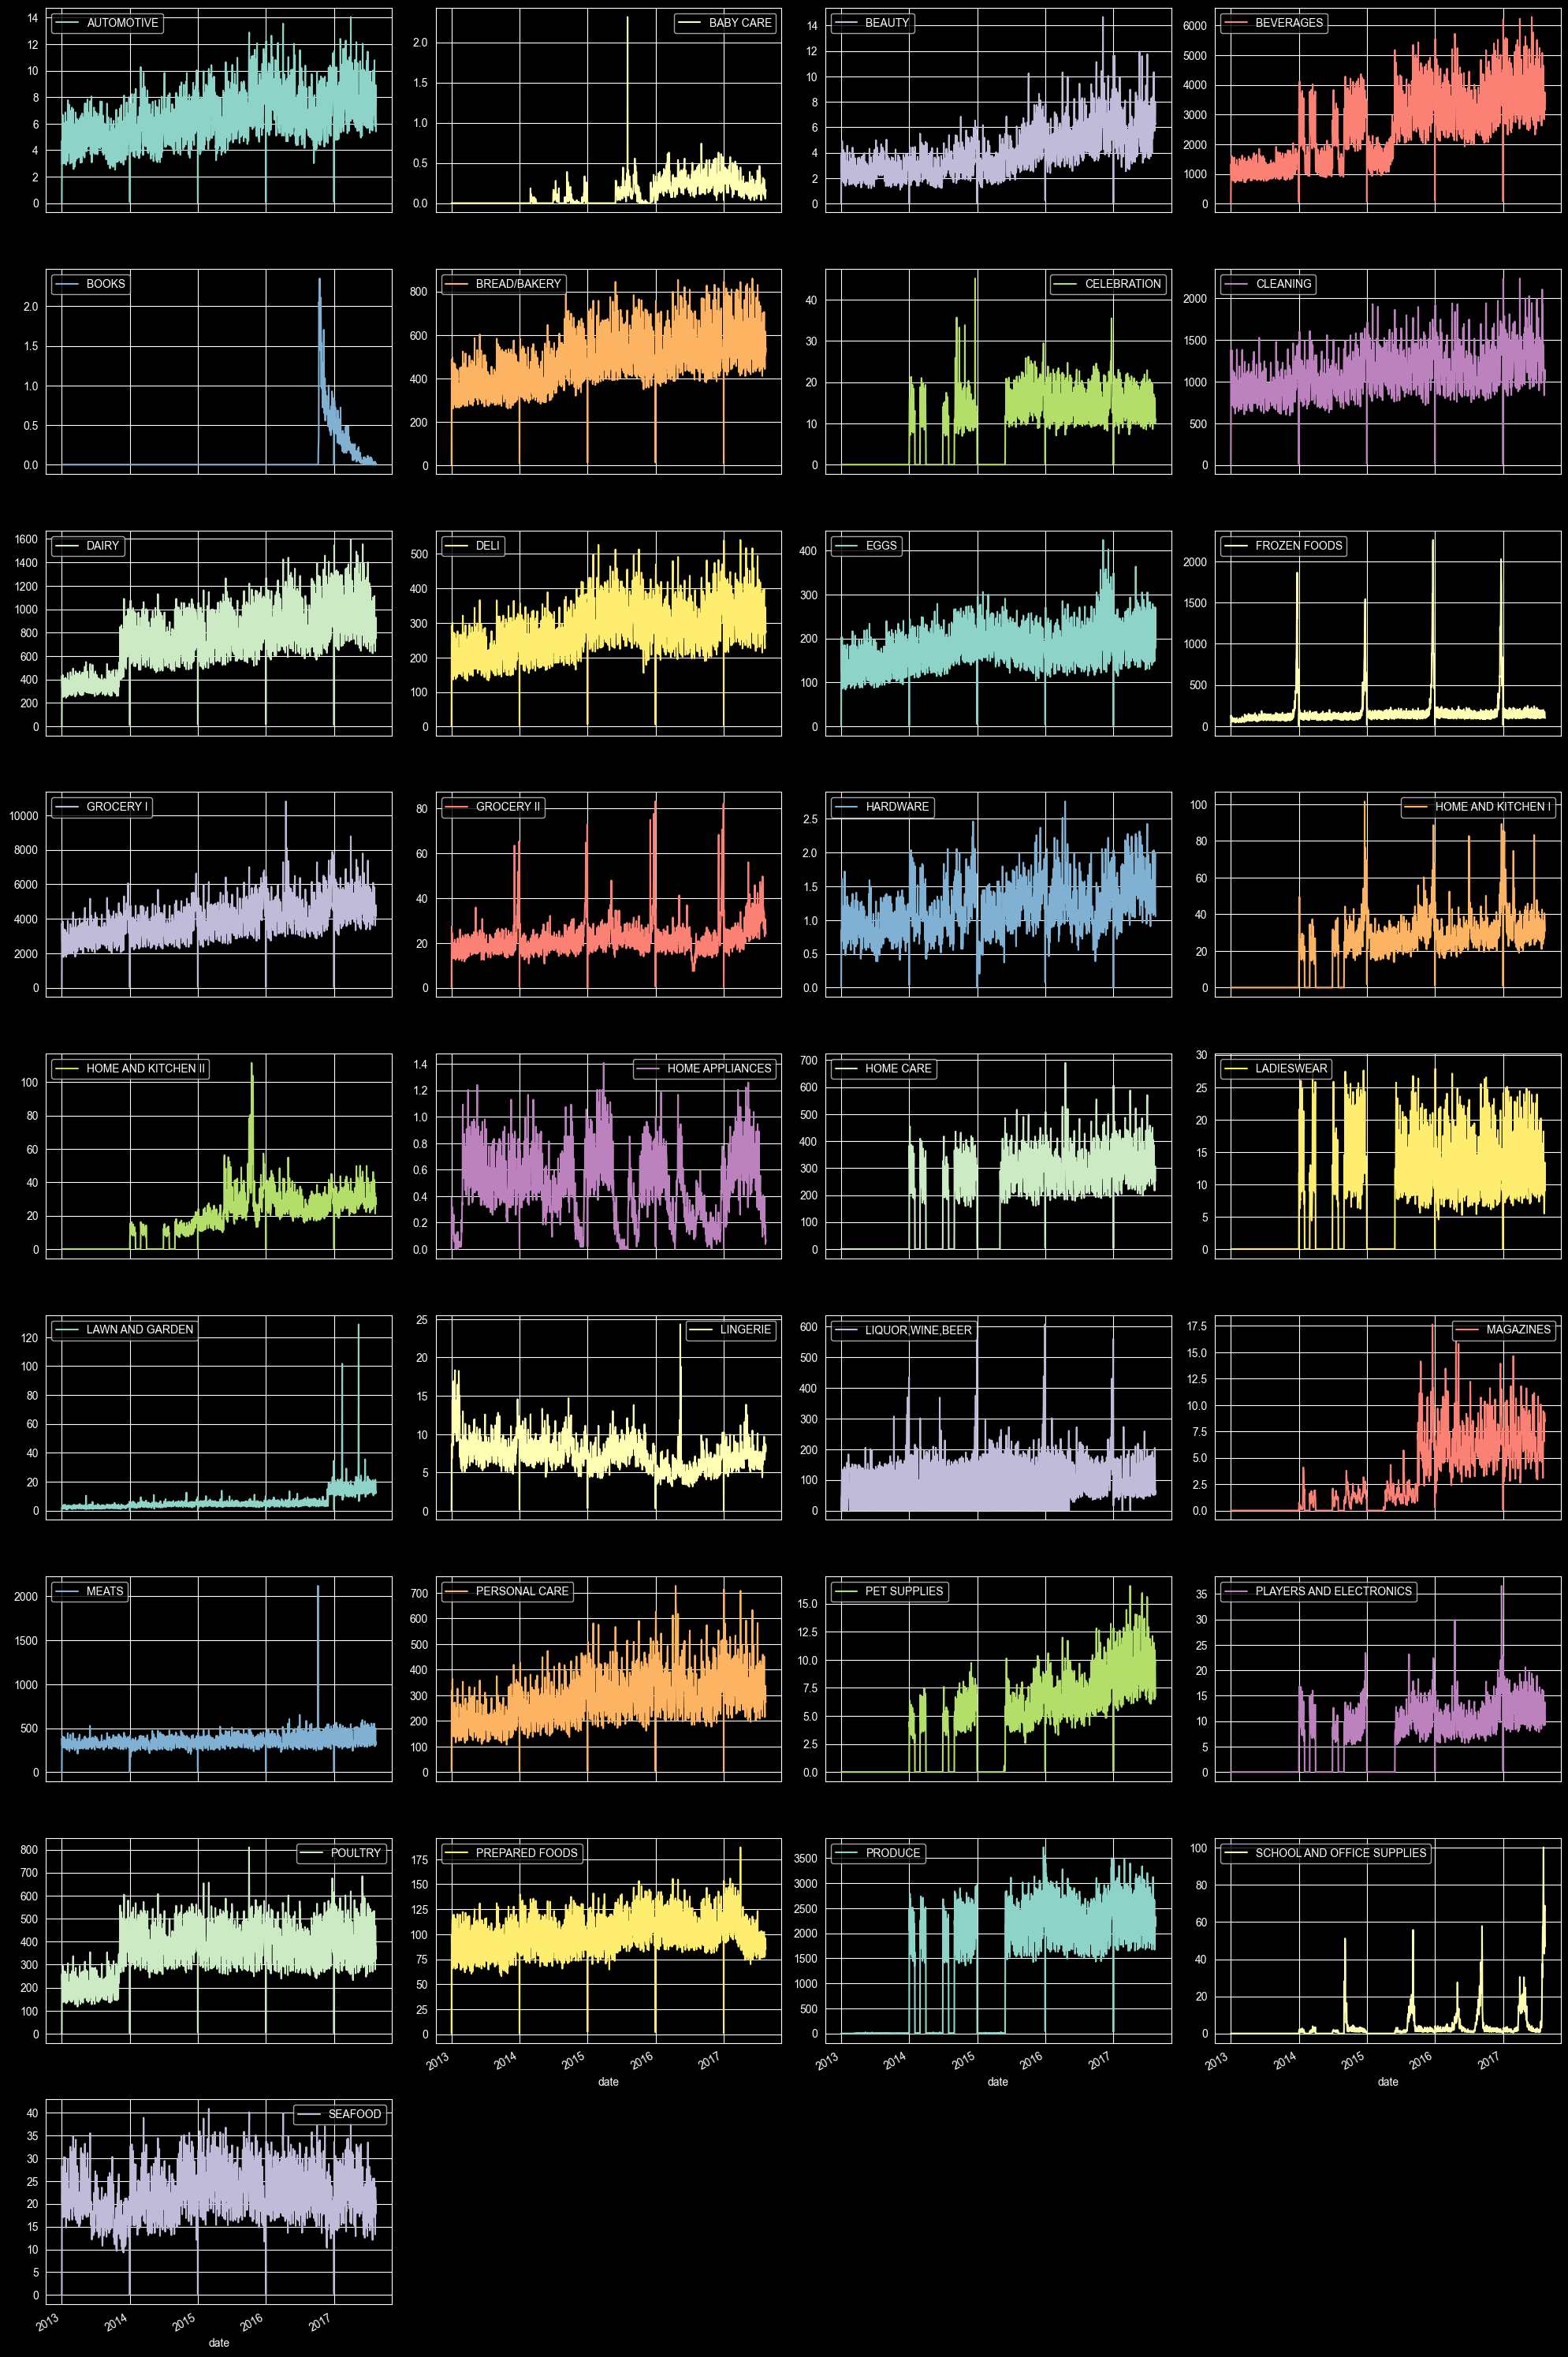

In [ ]:
average_sales_per_family = train.groupby(['date', 'family'])['sales'].mean()
axes = average_sales_per_family.unstack(level='family').plot(
    subplots=True,
    layout=(9, 4),      # Define a grade (9 linhas x 4 colunas para cobrir as 33 famílias)
    figsize=(20, 30),   
    sharex=True,
    sharey=False
)

plt.tight_layout()
plt.show()

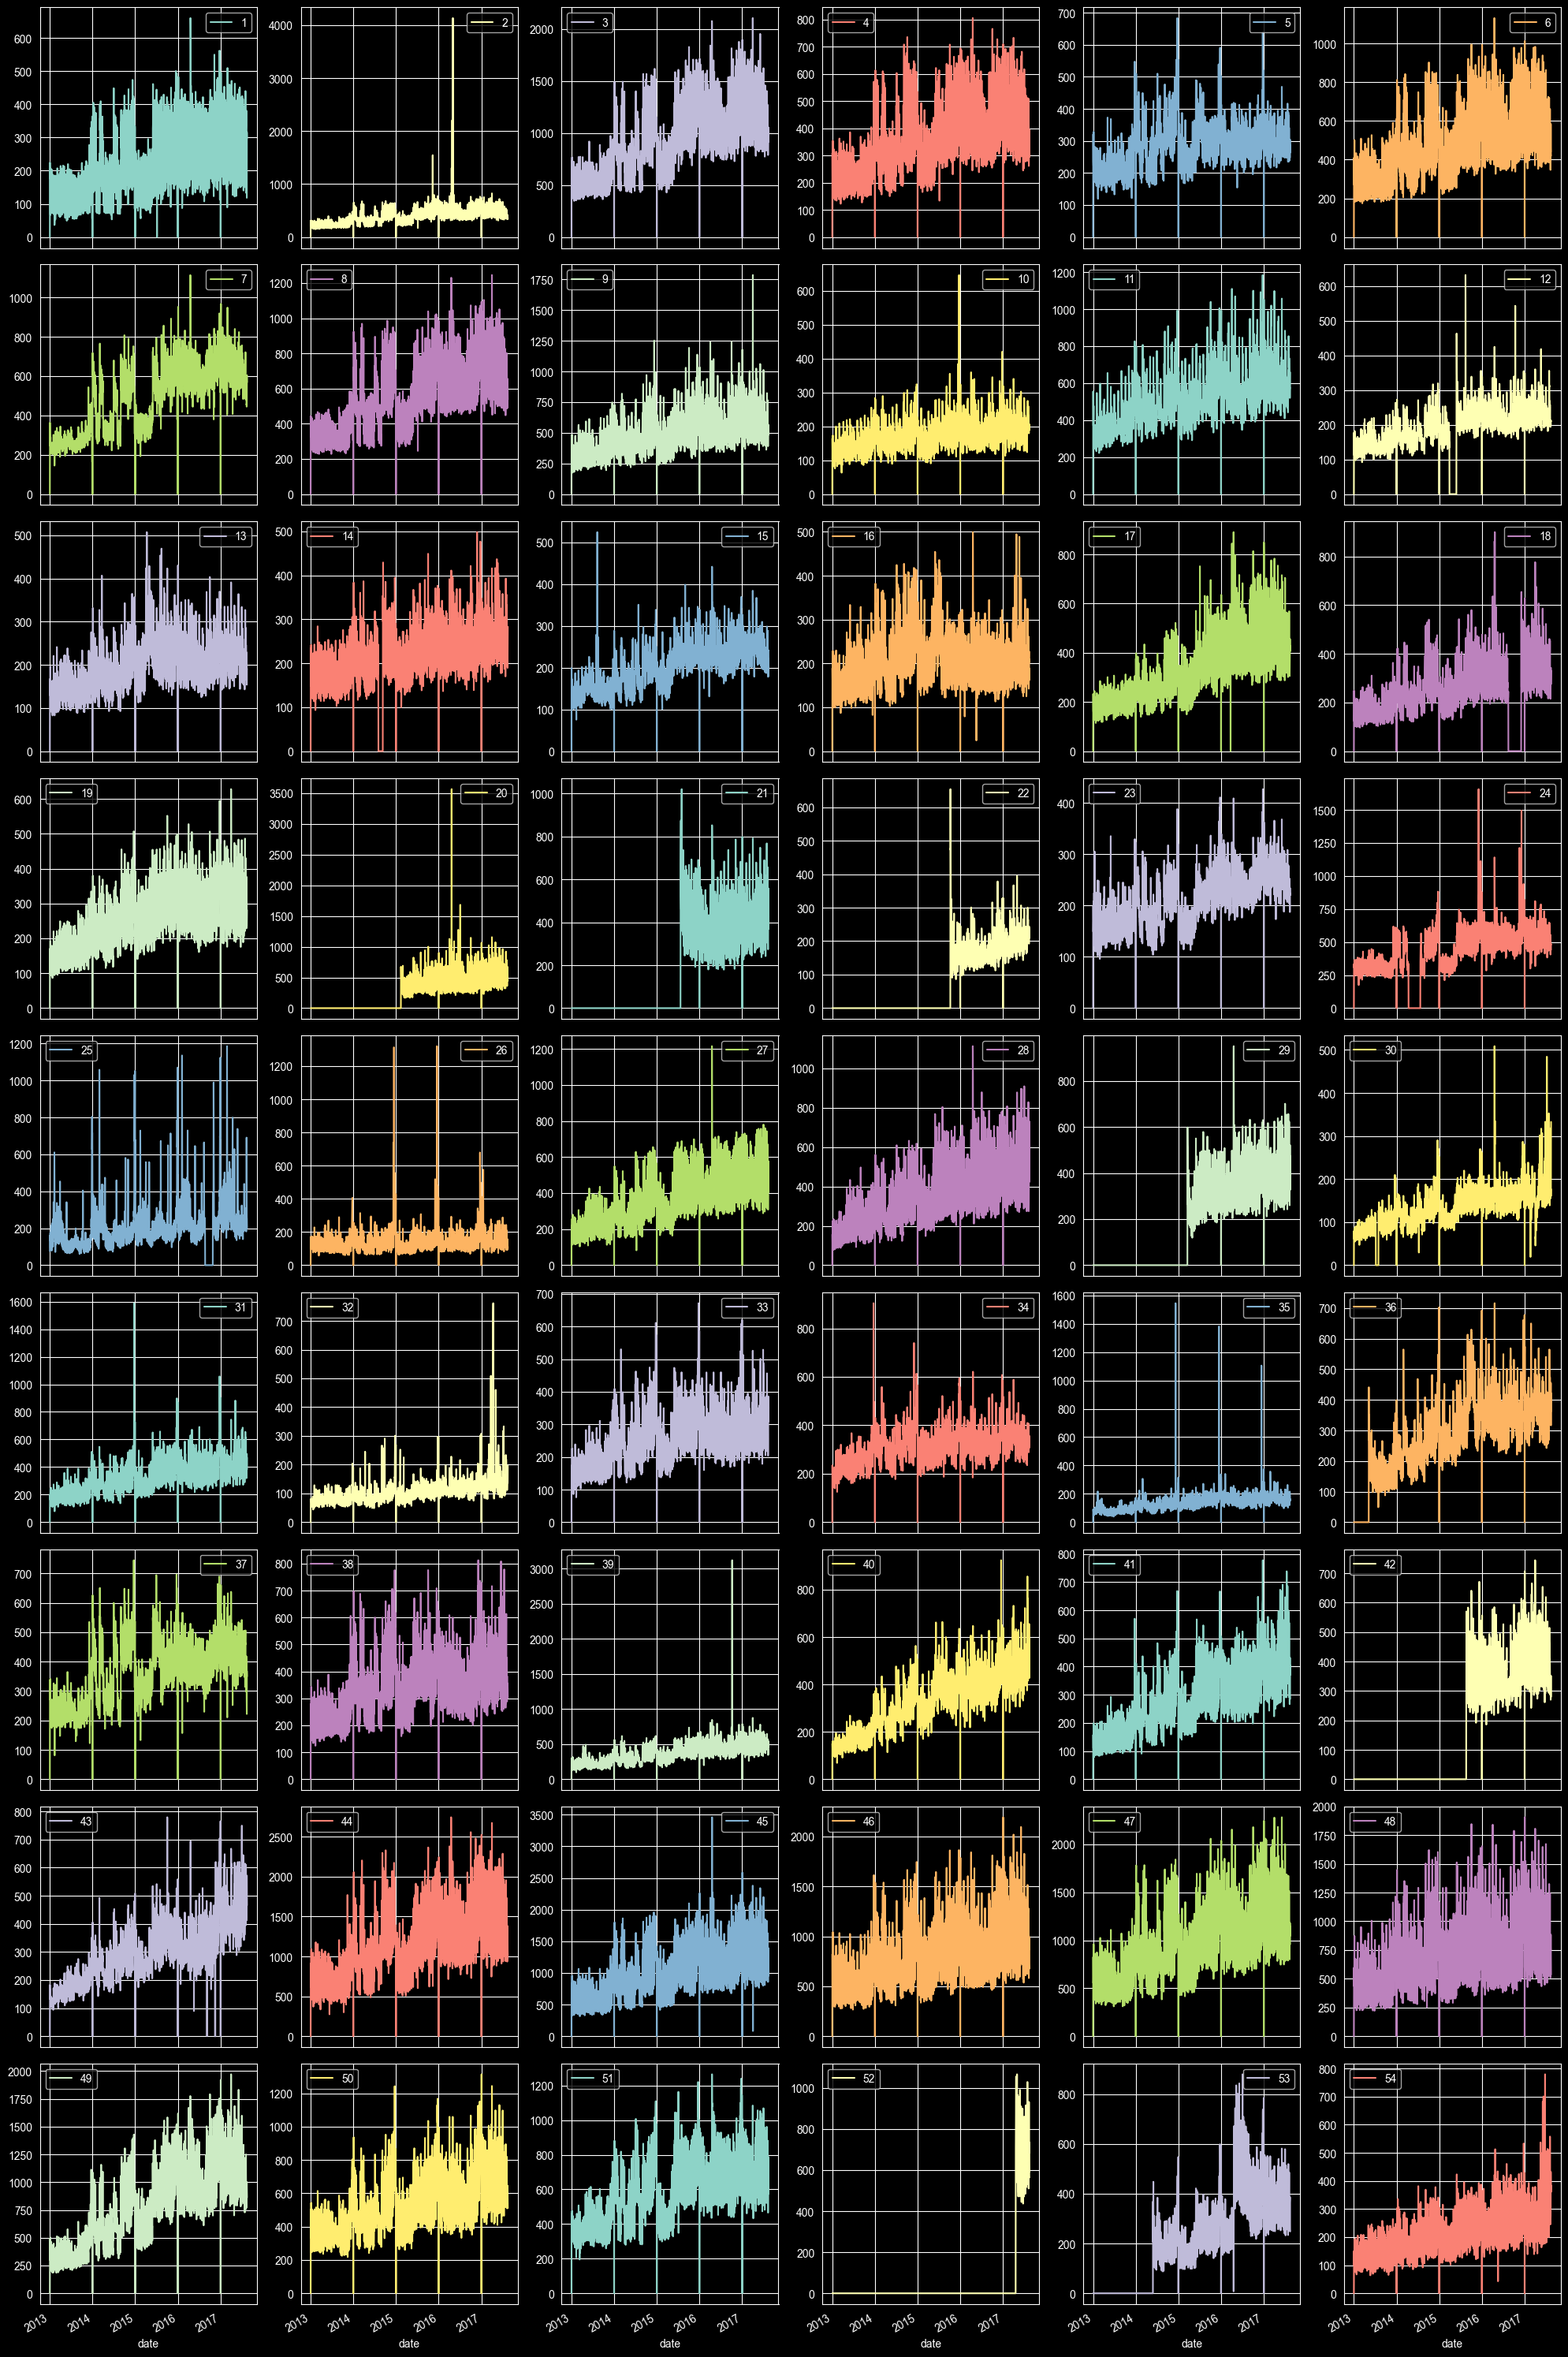

In [ ]:
average_sales_per_store = train.groupby(['date', 'store_nbr'])['sales'].mean()
axes = average_sales_per_store.unstack(level='store_nbr').plot(
    subplots=True,
    layout=(9, 6),      # Define a grade (9 linhas x 6 colunas para cobrir as 54 lojas)
    figsize=(20, 30),   
    sharex=True,
    sharey=False
)

plt.tight_layout()
plt.show()

## Geração das features

In [4]:
# Junção dos datasets de treino e teste para gerar as features nos dados de teste
# Antes da concatenação é colocado um identificador em cada registro para saber se ele é de treino ou teste para usar na separação posterior
train['is_train'] = 1
test['is_train'] = 0
full_data = pd.concat([train, test], sort=False)
# Merges das tabelas
full_data = full_data.merge(oil, on='date', how='left')
full_data = full_data.merge(stores, on='store_nbr', how='left')
full_data.rename(columns={'type': 'store_type', 'cluster': 'store_cluster'}, inplace=True)
full_data = full_data.merge(holidays, on='date', how='left')
full_data.rename(columns={'type': 'holiday_type'}, inplace=True)
full_data['holiday_type'] = full_data['holiday_type'].fillna('Work Day')

In [5]:
dates = pd.DataFrame(full_data['date'].drop_duplicates())
dates['time_dummy'] = np.arange(len(dates))
full_data = pd.merge(dates, full_data, on='date', how='left')
full_data['day_of_week'] = full_data['date'].dt.dayofweek
full_data['day_of_year'] = full_data['date'].dt.dayofyear
full_data['day_of_month'] = full_data['date'].dt.day
full_data['month'] = full_data['date'].dt.month
full_data['is_weekend'] = (full_data['day_of_week'] >= 5).astype(int)
full_data['is_payday'] = ((full_data['day_of_month'] == 15) | full_data['date'].dt.is_month_end).astype(int)
full_data['sin_week'] = np.sin(2* np.pi * full_data['day_of_week'] / 7)
full_data['cos_week'] = np.cos(2* np.pi * full_data['day_of_week'] / 7)
full_data['sin_day_month'] = np.sin(2 * np.pi * full_data['day_of_month'] / full_data['date'].dt.days_in_month)
full_data['cos_day_month'] = np.cos(2 * np.pi * full_data['day_of_month'] / full_data['date'].dt.days_in_month)
full_data['sin_month_year'] = np.sin(2 * np.pi * full_data['month'] / 12)
full_data['cos_month_year'] = np.cos(2 * np.pi * full_data['month'] / 12)
days_in_year = np.where(full_data['date'].dt.is_leap_year, 366, 365)
days_in_year = pd.Series(days_in_year)
full_data['sin_day_year'] = np.sin(2 * np.pi * full_data['day_of_year'] / days_in_year)
full_data['cos_day_year'] = np.cos(2 * np.pi * full_data['day_of_year'] / days_in_year)
full_data = full_data.sort_values(['store_nbr', 'family', 'date'])
sales_per_store_family = full_data.groupby(['store_nbr', 'family'])['sales']
full_data['lag_16'] = sales_per_store_family.transform(lambda d: d.shift(16))
full_data['lag_16_mean_7'] = sales_per_store_family.transform(lambda d: d.shift(16).rolling(window=7, center=False).mean())
full_data['lag_16_mean_30'] = sales_per_store_family.transform(lambda d: d.shift(16).rolling(window=30, center=False).mean())
full_data['lag_16_mean_365'] = sales_per_store_family.transform(lambda d: d.shift(16).rolling(window=365, center=False).mean())

Para features de categorias utilizamos um label enconder para deixá-las enumeraveis

In [6]:
category_features = ['family', 'city', 'state', 'holiday_type', 'store_type', 'locale', 'locale_name', 'description']
le = LabelEncoder()
for feature in category_features:
    full_data[feature] = le.fit_transform(full_data[feature])

Aqui vamos fazer a remoção de registros com features de lag faltantes, para isso vamos ordenar o dataset de novo por data

In [7]:
full_data.sort_values(['date'])

,date,time_dummy,id,store_nbr,family,sales,onpromotion,is_train,dcoilwtico,city,...,sin_day_month,cos_day_month,sin_month_year,cos_month_year,sin_day_year,cos_day_year,lag_16,lag_16_mean_7,lag_16_mean_30,lag_16_mean_365
0,2013-01-01,0,0,1,0,0.0,0,1,93.139999,18,...,2.012985e-01,0.97953,0.500000,0.866025,0.017213,0.999852,NaN,NaN,NaN,NaN
1313,2013-01-01,0,1313,45,26,0.0,0,1,93.139999,18,...,2.012985e-01,0.97953,0.500000,0.866025,0.017213,0.999852,NaN,NaN,NaN,NaN
1771,2013-01-01,0,1771,9,22,0.0,0,1,93.139999,18,...,2.012985e-01,0.97953,0.500000,0.866025,0.017213,0.999852,NaN,NaN,NaN,NaN
1312,2013-01-01,0,1312,45,25,0.0,0,1,93.139999,18,...,2.012985e-01,0.97953,0.500000,0.866025,0.017213,0.999852,NaN,NaN,NaN,NaN
1772,2013-01-01,0,1772,9,23,0.0,0,1,93.139999,18,...,2.012985e-01,0.97953,0.500000,0.866025,0.017213,0.999852,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082071,2017-08-31,1699,3028611,37,3,NaN,41,0,47.259998,3,...,-2.449294e-16,1.00000,-0.866025,-0.500000,-0.863142,-0.504961,2232.000000,2230.714286,2878.40000,2843.989041
3082072,2017-08-31,1699,3028612,37,4,NaN,0,0,47.259998,3,...,-2.449294e-16,1.00000,-0.866025,-0.500000,-0.863142,-0.504961,0.000000,0.000000,0.00000,0.704110
3082073,2017-08-31,1699,3028613,37,5,NaN,12,0,47.259998,3,...,-2.449294e-16,1.00000,-0.866025,-0.500000,-0.863142,-0.504961,446.971985,453.757996,504.99286,576.021162
3082062,2017-08-31,1699,3028602,36,27,NaN,0,0,47.259998,11,...,-2.449294e-16,1.00000,-0.866025,-0.500000,-0.863142,-0.504961,4.000000,3.000000,3.60000,6.304110


Aqui removemos os registros com a coluna de lag_16_mean_365, que por sua vez também vai remover os registros com as outras colunas de lag faltantes

In [10]:
full_data = full_data.dropna(subset=['lag_16_mean_365'])
split_date = full_data.iloc[int(len(full_data) * 0.7)]['date']

Amostra dos dados.
Os que possuem valores de venda faltantes são dos dados de teste

In [11]:
full_data.head()

,date,time_dummy,id,store_nbr,family,sales,onpromotion,is_train,dcoilwtico,city,...,sin_day_month,cos_day_month,sin_month_year,cos_month_year,sin_day_year,cos_day_year,lag_16,lag_16_mean_7,lag_16_mean_30,lag_16_mean_365
677160,2014-01-12,375,668250,1,0,2.0,0,1,92.389999,18,...,0.651372,-0.758758,0.5,0.866025,0.205104,0.978740,6.0,2.142857,1.733333,2.136986
678942,2014-01-13,376,670032,1,0,3.0,0,1,91.449997,18,...,0.485302,-0.874347,0.5,0.866025,0.221922,0.975065,4.0,2.000000,1.833333,2.147945
680724,2014-01-14,377,671814,1,0,1.0,0,1,92.150002,18,...,0.299363,-0.954139,0.5,0.866025,0.238673,0.971100,0.0,2.000000,1.800000,2.142466
682506,2014-01-15,378,673596,1,0,2.0,0,1,93.779999,18,...,0.101168,-0.994869,0.5,0.866025,0.255353,0.966848,1.0,2.142857,1.833333,2.136986
684288,2014-01-16,379,675378,1,0,4.0,0,1,93.540001,18,...,-0.101168,-0.994869,0.5,0.866025,0.271958,0.962309,2.0,2.285714,1.900000,2.134247


Aqui é onde definimos a divisão do conjunto de treino em treino e validação por meio de uma data

In [12]:
split_date

Timestamp('2015-06-29 00:00:00')

## Treinamento do modelo

Divisão dos dados em treino, validação e teste

In [13]:
train_data = full_data[(full_data['is_train'] == 1) & (full_data['date'] < split_date)]
validation_data = full_data[(full_data['is_train'] == 1) & (full_data['date'] >= split_date)]
test_data = full_data[full_data['is_train'] == 0]

In [14]:
X_train = train_data.drop(['id', 'date', 'sales'], axis=1)
Y_train = train_data['sales']
X_validation = validation_data.drop(['id', 'date', 'sales'], axis=1)
Y_validation = validation_data['sales']
X_test = test_data.drop(['id', 'date', 'sales'], axis=1)

Escolhemos aqui o modelo XGBoost, com a métrica de erro do root mean squared error

In [15]:
model = xgb.XGBRegressor(objective='reg:squaredlogerror', eval_metric='rmsle')
model.fit(X_train, Y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squaredlogerror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_

## Previsões do modelo

In [16]:
prediction_train = np.maximum(model.predict(X_train), 0)
prediction_validation = np.maximum(model.predict(X_validation), 0)
train_error = root_mean_squared_log_error(Y_train, prediction_train)
validation_error = root_mean_squared_log_error(Y_validation, prediction_validation)
print(f'Train error: {train_error}\nValidation error: {validation_error}')

Train error: 1.3896397352218628
Validation error: 1.2775474786758423


Aqui temos a previsão em cima dos dados de teste, que é salva em um arquivo .csv para ser submetido na plataforma do Kaggle

In [17]:
prediction_test = np.maximum(model.predict(X_test), 0)
submission = pd.DataFrame({'id': test_data['id'], 'sales': prediction_test})
submission.to_csv('submissions/second_submission.csv', index=False)